In [1]:
# Import modules
from matplotlib import pyplot as plt
import numpy as np
import math
import scipy
import pandas as pd
import glob, os
from sklearn import linear_model

In [2]:
# Error calculations
def error_prep_calc(x,y,intercept='VARIABLE'):
    if intercept == 'FIXED':
        xy = x * y
        x_squared = x**2
        n = len(x)

        m = sum(xy)/sum(x_squared)

        #predicted y
        y_hat = [m * xi for xi in x]

        y_dif = (y - y_hat)**2

        #std dev of regression
        Sr = (sum(y_dif)/(n-2))**0.5

        #std dev of slope
        Sm = ((n*Sr**2)/(n*sum(x_squared)-sum(x)**2))**0.5

        #Calculate critical value for 95% confidence interval 
        crit_t = scipy.stats.t.ppf(1-0.025, n-2)

        #slope confidence interval
        t_Sm = crit_t*Sm

    elif intercept == 'VARIABLE':
        xy = x * y
        x_squared = x**2
        n = len(x)

        m = (n * sum(xy) - sum(x) * sum(y))/(n * sum(x_squared) - sum(x)**2)

        c = (sum(y) - m * sum(x))/n

        #Eq is y = mx + c
        # To use regression through the origin you can instead use: sum(xy)/sum(x_squared) to calculate m

        #predicted y
        y_hat = [m * xi + c for xi in x]

        y_dif = (y - y_hat)**2

        #std dev of regression
        Sr = (sum(y_dif)/(n-2))**0.5

        #std dev of slope
        Sm = ((n*Sr**2)/(n*sum(x_squared)-sum(x)**2))**0.5

        #std dev of intercept
        Sc = ((Sr**2*sum(x_squared))/(n*sum(x_squared)-sum(x)**2))**0.5

        #Calculate critical value for 99% confidence interval 
        crit_t = scipy.stats.t.ppf(1-0.005, n-2)

        #slope confidence interval
        t_Sm = crit_t*Sm

        #intercept confidence interval
        t_Sc = crit_t*Sc

    else:
        raise TypeError("Intercept should be FIXED or VARIABLE")
    return x, y, Sr, m, n, np.mean(y), np.mean(x), crit_t

def simple_error_calc(x, y, Sr, m, n, mean_y, mean_x, sample, crit_t, reps=1):

    conc = sample/m

    #std dev sample conc
    S_sample = (Sr/m)*(1/reps + 1/n + ((sample-mean_y)/(m**2)*sum(x-mean_x)))**0.5

    t_Sm_sample = crit_t*S_sample
    
    return(conc, t_Sm_sample)

In [16]:
def file_import(path,file_extension,tstart = 140, tstop = 175):
    #import the list of files and sort them
    file_list = glob.glob(os.path.join(path, '*.'+str(file_extension)))
    no_files = len(file_list)

    #Create df to store integrated data
    if file_extension == 'TXT':
        with open(file_list[0]) as f:
            first_line = f.readline().strip('\n')
        elements = (first_line[first_line.index(':')+1:][1:]+'').split(',')
        summarydf = pd.DataFrame(columns=elements)
    elif file_extension == 'FIN2':
        with open(file_list[0]) as f:
            var_list = f.readlines()[7][:-1]
        elements = var_list.split(',')
        summarydf = pd.DataFrame(columns=elements[1:])
    else:
        raise TypeError("File Extension should be either TXT or FIN2")
    #print number of files and file list
    print(no_files)
    print('Elements',summarydf.keys())
    
    TRA_fig,axs = plt.subplots(figsize=(16,25),nrows = math.ceil(len(elements)/3),ncols = 3)
    plt.subplots_adjust(hspace=0.4,wspace=0.3)
    axs=axs.flatten()

    # CHOOSE BACKGROUND RUN NAME (shouldn't need to change)
    if file_extension == 'TXT':
        for file in file_list:
            with open(file) as f:
                first_line = f.readline().strip('\n')
            colnames = ('Time'+first_line[first_line.index(':')+1:]+'').split(',')
            if '_0ppb' in file:
                    backgrounddf = pd.read_csv(file,delimiter=',',header = 4, names=colnames,index_col=False)
    elif file_extension == 'FIN2':
        for file in file_list:
            with open(file) as f:
                first_line = f.readline()[7].strip('\n')
            colnames = var_list.split(',')#('Time'+first_line[first_line.index(':')+1:]+'').split(',')
            if '_0pp' in file:
                    backgrounddf = pd.read_csv(file,delimiter=',',header = 7, names=colnames,index_col=False)
                    
    for file in file_list:
        if file_extension == 'TXT':
            with open(file) as f:
                first_line = f.readline().strip('\n')
            colnames = ('Time'+first_line[first_line.index(':')+1:]+'').split(',')
            df = pd.read_csv(file,delimiter=',',header = 4, names=colnames,index_col=False)
            # Separate name of sample
            text = file.replace(path+'/','')
            sep = '.'
            stripped = text.split(sep, 1)[0]
            name = stripped.removeprefix(path)
        elif file_extension == 'FIN2':
            with open(file) as f:
                first_line = f.readline()[7].strip('\n')
            colnames = var_list.split(',')#('Time'+first_line[first_line.index(':')+1:]+'').split(',')
            df = pd.read_csv(file,delimiter=',',header = 7, names=colnames,index_col=False)
            # Separate name of sample
            text = file.replace(path+'/','')
            sep = '.'
            stripped = text.split(sep, 1)[0]
            name = stripped.removeprefix(path)
        results = []


        for i, variable in enumerate(df.keys()):
            if variable in ['Time']:#,'As75(LR)', 'Se77(LR)', 'Se78(LR)', 'Se82(LR)', 'Mo95(LR)', 'Mo97(LR)', 'Ag107(LR)', 'Ag109(LR)', 'Cd111(LR)', 'Cd114(LR)', 'In115(LR)', 'Sn118(LR)', 'La139(LR)', 'Nd146(LR)', 'Ta181(LR)', 'Pb204(LR)', 'Pb206(LR)', 'Pb207(LR)', 'Pb208(LR)', 'Hg200(LR)']:
                ind=0
                continue
            else:
                axs[ind].plot(df['Time'],df[variable],label=name)
                axs[ind].set_xlabel('Time (s)')
                axs[ind].set_ylabel('Signal (counts)')
                # # Precon Mode (when running TRA for precon only runs)
                # CHANGE THE BEGINNING AND END OF THE INTEGRATION (IF NECESSARY)
                #tstart = 140
                #tstop = 175

                axs[ind].axvspan(xmin = df['Time'][tstart], xmax = df['Time'][tstop],alpha=0.1,color='k')
                if file_extension == 'TXT':
                    results.append((sum(df[variable][tstart:tstop])/(sum(df['In115(LR)'][tstart:tstop])-sum(df['Sn118(LR)'][tstart:tstop])*0.14))-(sum(backgrounddf[variable][tstart:tstop])/(sum(backgrounddf['In115(LR)'][tstart:tstop])-sum(backgrounddf['Sn118(LR)'][tstart:tstop])*0.14)))
                elif file_extension == 'FIN2':
                    results.append((sum(df[variable][tstart:tstop])/(sum(df['In115'][tstart:tstop])-sum(df['Sn118'][tstart:tstop])*0.14))-(sum(backgrounddf[variable][tstart:tstop])/(sum(backgrounddf['In115'][tstart:tstop])-sum(backgrounddf['Sn118'][tstart:tstop])*0.14)))
                axs[ind].set_title(variable)
                # axs[ind].set_xlim(450,550)
                # axs[ind].set_xlim(0,750)
                # axs[ind].legend()
                ind=ind+1
        summarydf.loc[name]=results
    # axs[9].set_ylim((0,1e6))
    display(summarydf.sort_index())
    return summarydf, elements

def calibration_calculation(summarydf, cal_stds, min_r2, elements):
    fig,axs = plt.subplots(figsize=(16,30),nrows = math.ceil(len(elements)/3),ncols = 3)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    axs=axs.flatten()

    # Calculate std concentrations based on dilutions
    STDdf = summarydf.filter(like='STD', axis=0)
    stds = np.zeros(len(STDdf))
    for i, text in enumerate(STDdf.index):
        stripped = text.split('_')
        std = 'cal_'+stripped[1]
        units = stripped[1][-3:]
        dil = stripped[2].replace('x','')
        stds[i]=cal_stds[std]/eval(dil)
    # calibration line
    cal = np.zeros(len(summarydf.keys()))
    error_cal = []

    for i, variable in enumerate(STDdf):
        # No need to calculate calibration line for internal standard as normalising based on it
        if 'In115' in variable:
            cal[i]=math.nan
            error_cal.append([np.empty(2),np.empty(2),np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
        else:
            x = stds
            y = STDdf[variable]

            axs[i].scatter(x,y,c='k')
            axs[i].set_title(variable)
            axs[i].set_xlabel(f'Concentration ({units})')
            axs[i].set_ylabel('Signal normalised to In minus background')

            #Best fit 
            lm = linear_model.LinearRegression(fit_intercept = False)
            model = lm.fit(x.reshape(-1, 1),np.array(y))
            rsquared = lm.score(x.reshape(-1, 1),np.array(y))
            cal[i] = model.coef_[0]
            xrange = np.array([min(x),max(x)]).reshape(-1,1)
            ypred = lm.predict(xrange)
                    # Set quality limit on required r2 for correlation line and save value for concentration calculation in samples
            if rsquared < min_r2:
                cal[i]=math.nan
                axs[i].plot(xrange,ypred,'r--')
                axs[i].text(0.1,0.9,'$R^2 = {0:.5f}$'.format(rsquared),c='r',transform=axs[i].transAxes)
                error_cal.append([np.empty(2),np.empty(2),np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
                cal[i] = np.nan
            else:
                axs[i].plot(xrange,ypred,'g--')
                axs[i].text(0.1,0.9,'$R^2 = {0:.5f}$'.format(rsquared),c='g',transform=axs[i].transAxes)
                lm = linear_model.LinearRegression(fit_intercept = False)
                model = lm.fit(np.array(y).reshape(-1, 1),x)
                score = lm.score(np.array(y).reshape(-1, 1),x)
                cal[i] = model.coef_[0]
                error_cal.append(error_prep_calc(np.array(x),np.array(y),intercept='FIXED'))
    
    concentrations=summarydf.copy()
    errors=summarydf.copy()
    for i, variable in enumerate(concentrations):
        concentrations[variable]=cal[i]*summarydf[variable]
        x,y,Sr,m,n,mean_y,mean_x,crit_t = error_cal[i]
        errors[variable] = simple_error_calc(x,y,Sr,m,n,mean_y,mean_x,crit_t,summarydf[variable])[1]
    return concentrations.sort_index(), errors.sort_index(), units

17
Elements Index(['Al27', 'As75', 'Se77', 'Se78', 'Se82', 'Ag107', 'Ag109', 'Cd111',
       'Cd114', 'In115', 'Sn118', 'La139', 'Nd146', 'Pb204', 'Pb206', 'Pb207',
       'Pb208', 'Hg200', 'Kr83'],
      dtype='object')


,Al27,As75,Se77,Se78,Se82,Ag107,Ag109,Cd111,Cd114,In115,Sn118,La139,Nd146,Pb204,Pb206,Pb207,Pb208,Hg200,Kr83
CON_Blank_10x,0.140820,0.079074,0.020155,-0.026393,-3.231508e-07,-0.000223,-0.000034,0.000018,0.000061,0.000022,0.000155,0.000066,-0.000068,-0.000039,0.000032,-0.000043,0.000113,0.000006,-0.000271
SMP_Blank,-0.226363,-0.115628,-0.035625,0.042376,1.331144e-04,0.001812,-0.000063,0.000072,-0.000045,-0.000050,-0.000359,0.000943,0.000196,-0.000134,0.000126,0.000199,0.000141,-0.000018,-0.000426
SMP_SW_10x,-0.123622,-0.117106,-0.033276,0.127133,7.473696e-04,0.002001,-0.000106,0.000238,0.000506,-0.000018,-0.000131,0.000978,0.000098,0.000030,0.001336,0.000589,0.002200,0.000250,-0.000116
SMP_SW_1x,-0.262875,-0.090185,-0.028102,0.059440,4.137453e-03,0.001018,-0.000101,0.003240,0.005846,0.000975,0.006961,0.008003,0.000504,0.001976,0.007599,0.006071,0.013984,0.007501,-0.000671
SMP_SW_2x,-0.199971,-0.113520,-0.034966,-0.051698,1.429924e-03,0.001944,-0.000276,0.001680,0.002461,0.000504,0.003600,0.003960,0.000223,0.000699,0.004152,0.003365,0.006601,0.002257,-0.000595
SMP_SW_5x,-0.189728,-0.113879,-0.035214,0.019270,7.256625e-04,0.002414,-0.000170,0.000460,0.000893,0.000090,0.000641,0.001730,0.000094,0.000271,0.001916,0.001692,0.003226,0.000856,-0.000053
SMP_s1,-0.164707,-0.100313,-0.034501,0.033960,9.298578e-04,0.000625,-0.000131,0.013375,0.027777,0.000181,0.001292,0.020862,0.002261,0.004212,0.060802,0.053866,0.121967,0.000656,-0.001426
SMP_s5,0.430895,-0.101248,-0.031579,0.088816,6.831287e-04,0.002527,0.001272,0.019808,0.038369,0.002956,0.021113,0.023846,0.001824,0.006623,0.119452,0.100503,0.236227,0.000363,-0.001039
SMP_s9,0.770879,-0.100670,-0.032429,0.080905,7.925877e-04,0.001001,-0.000065,0.020927,0.038493,0.000477,0.003408,0.026740,0.002446,0.001423,0.023262,0.018603,0.043662,0.000290,-0.000747
STD_0ppt_1x,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


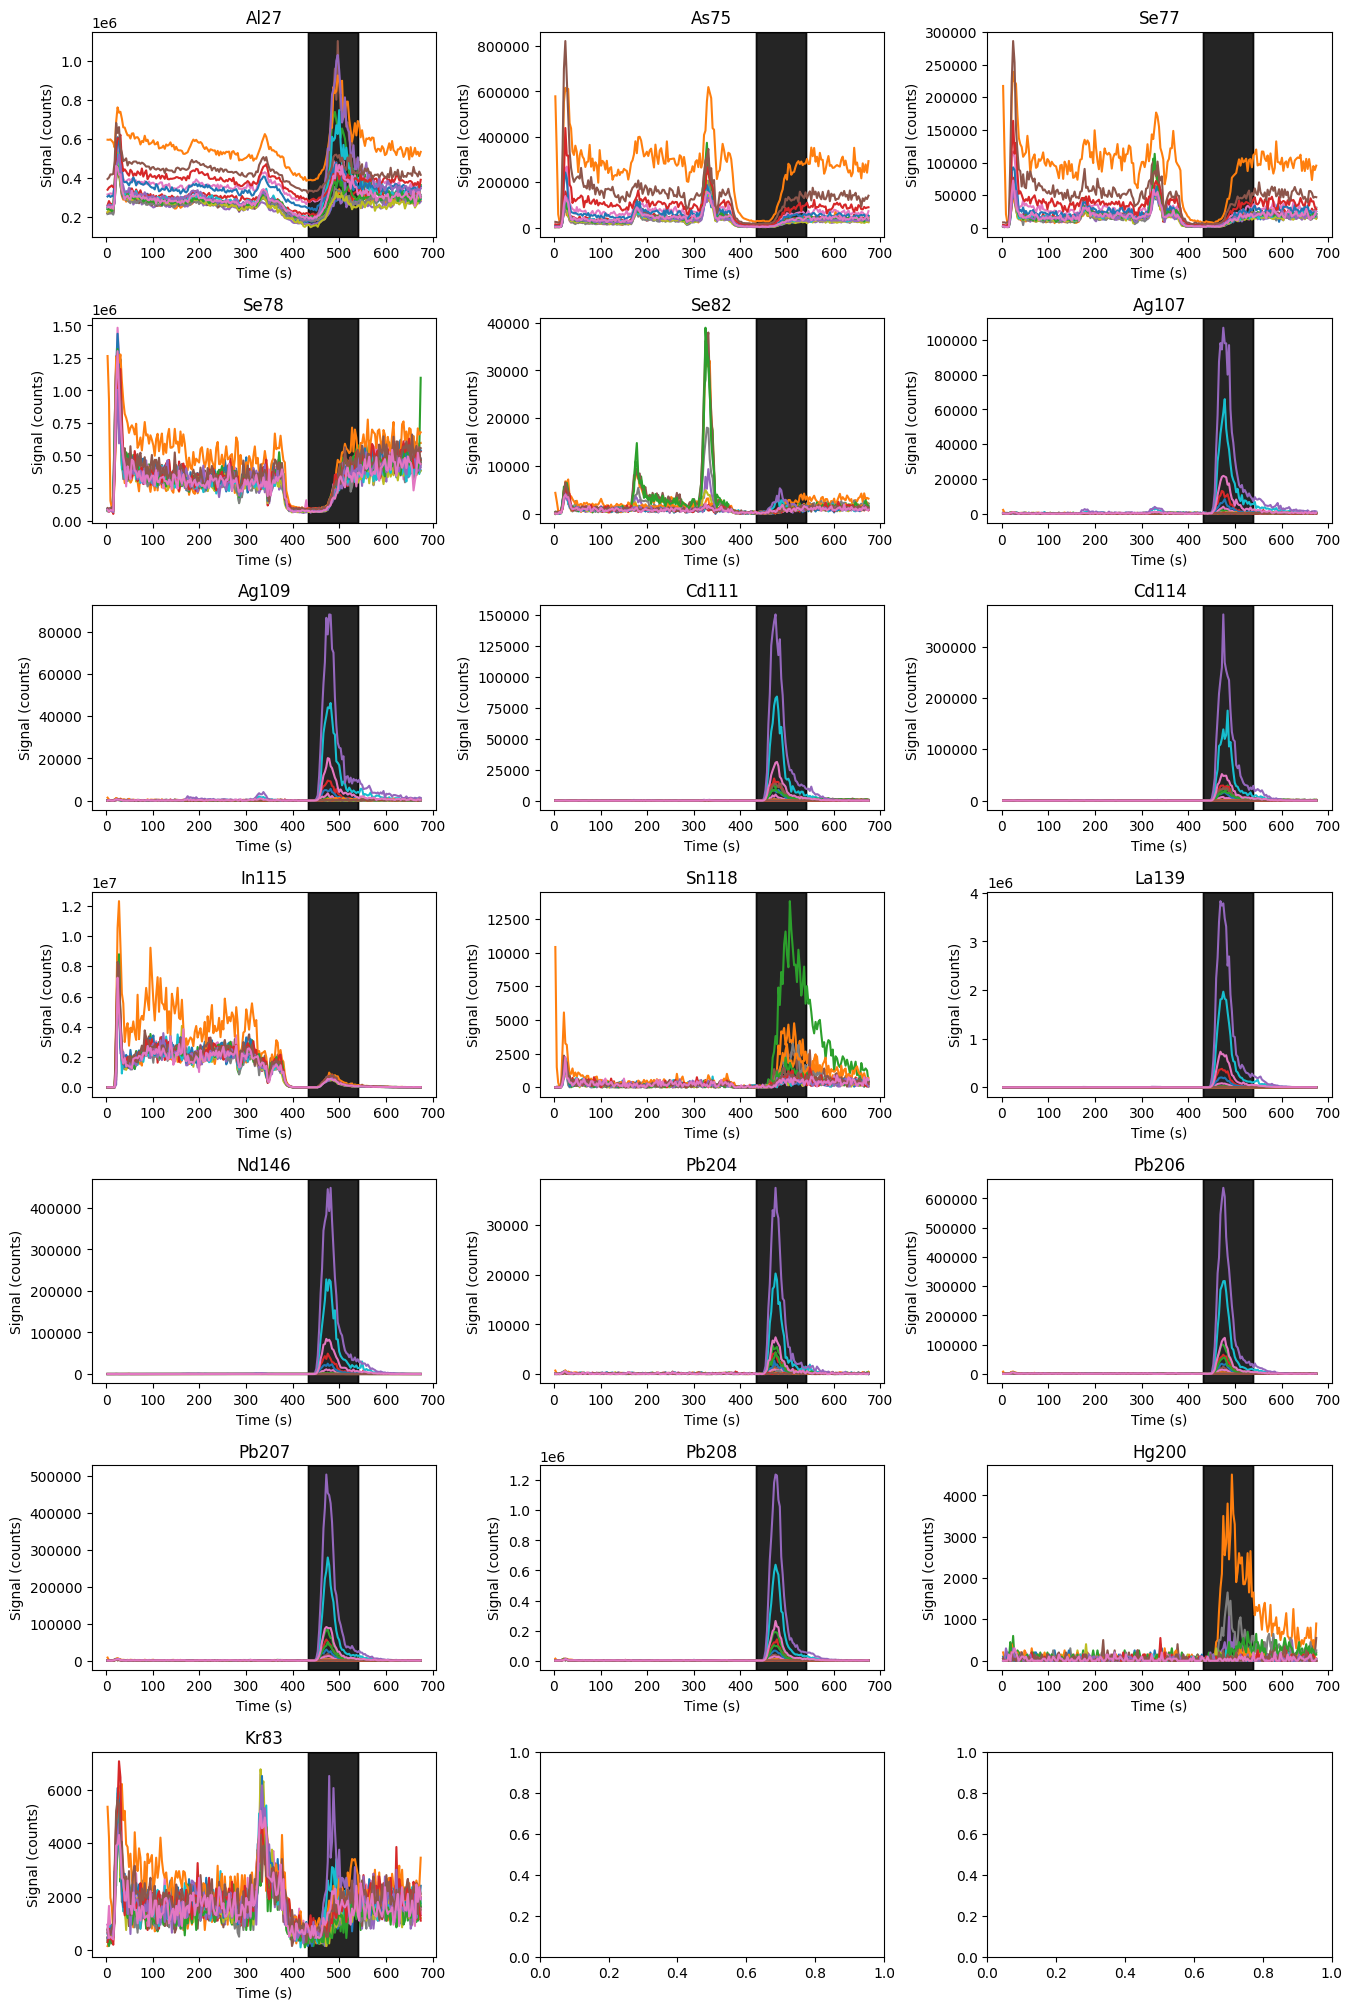

In [17]:
# SET THE DIRECTORY WHERE THE FILES ARE (These are the individual TRA files from the Element)
path = '/Users/hjb62/Python/ICP-MS TRA/Example Data copy'
file_extension='FIN2'
summarydf, elements = file_import(path,file_extension)

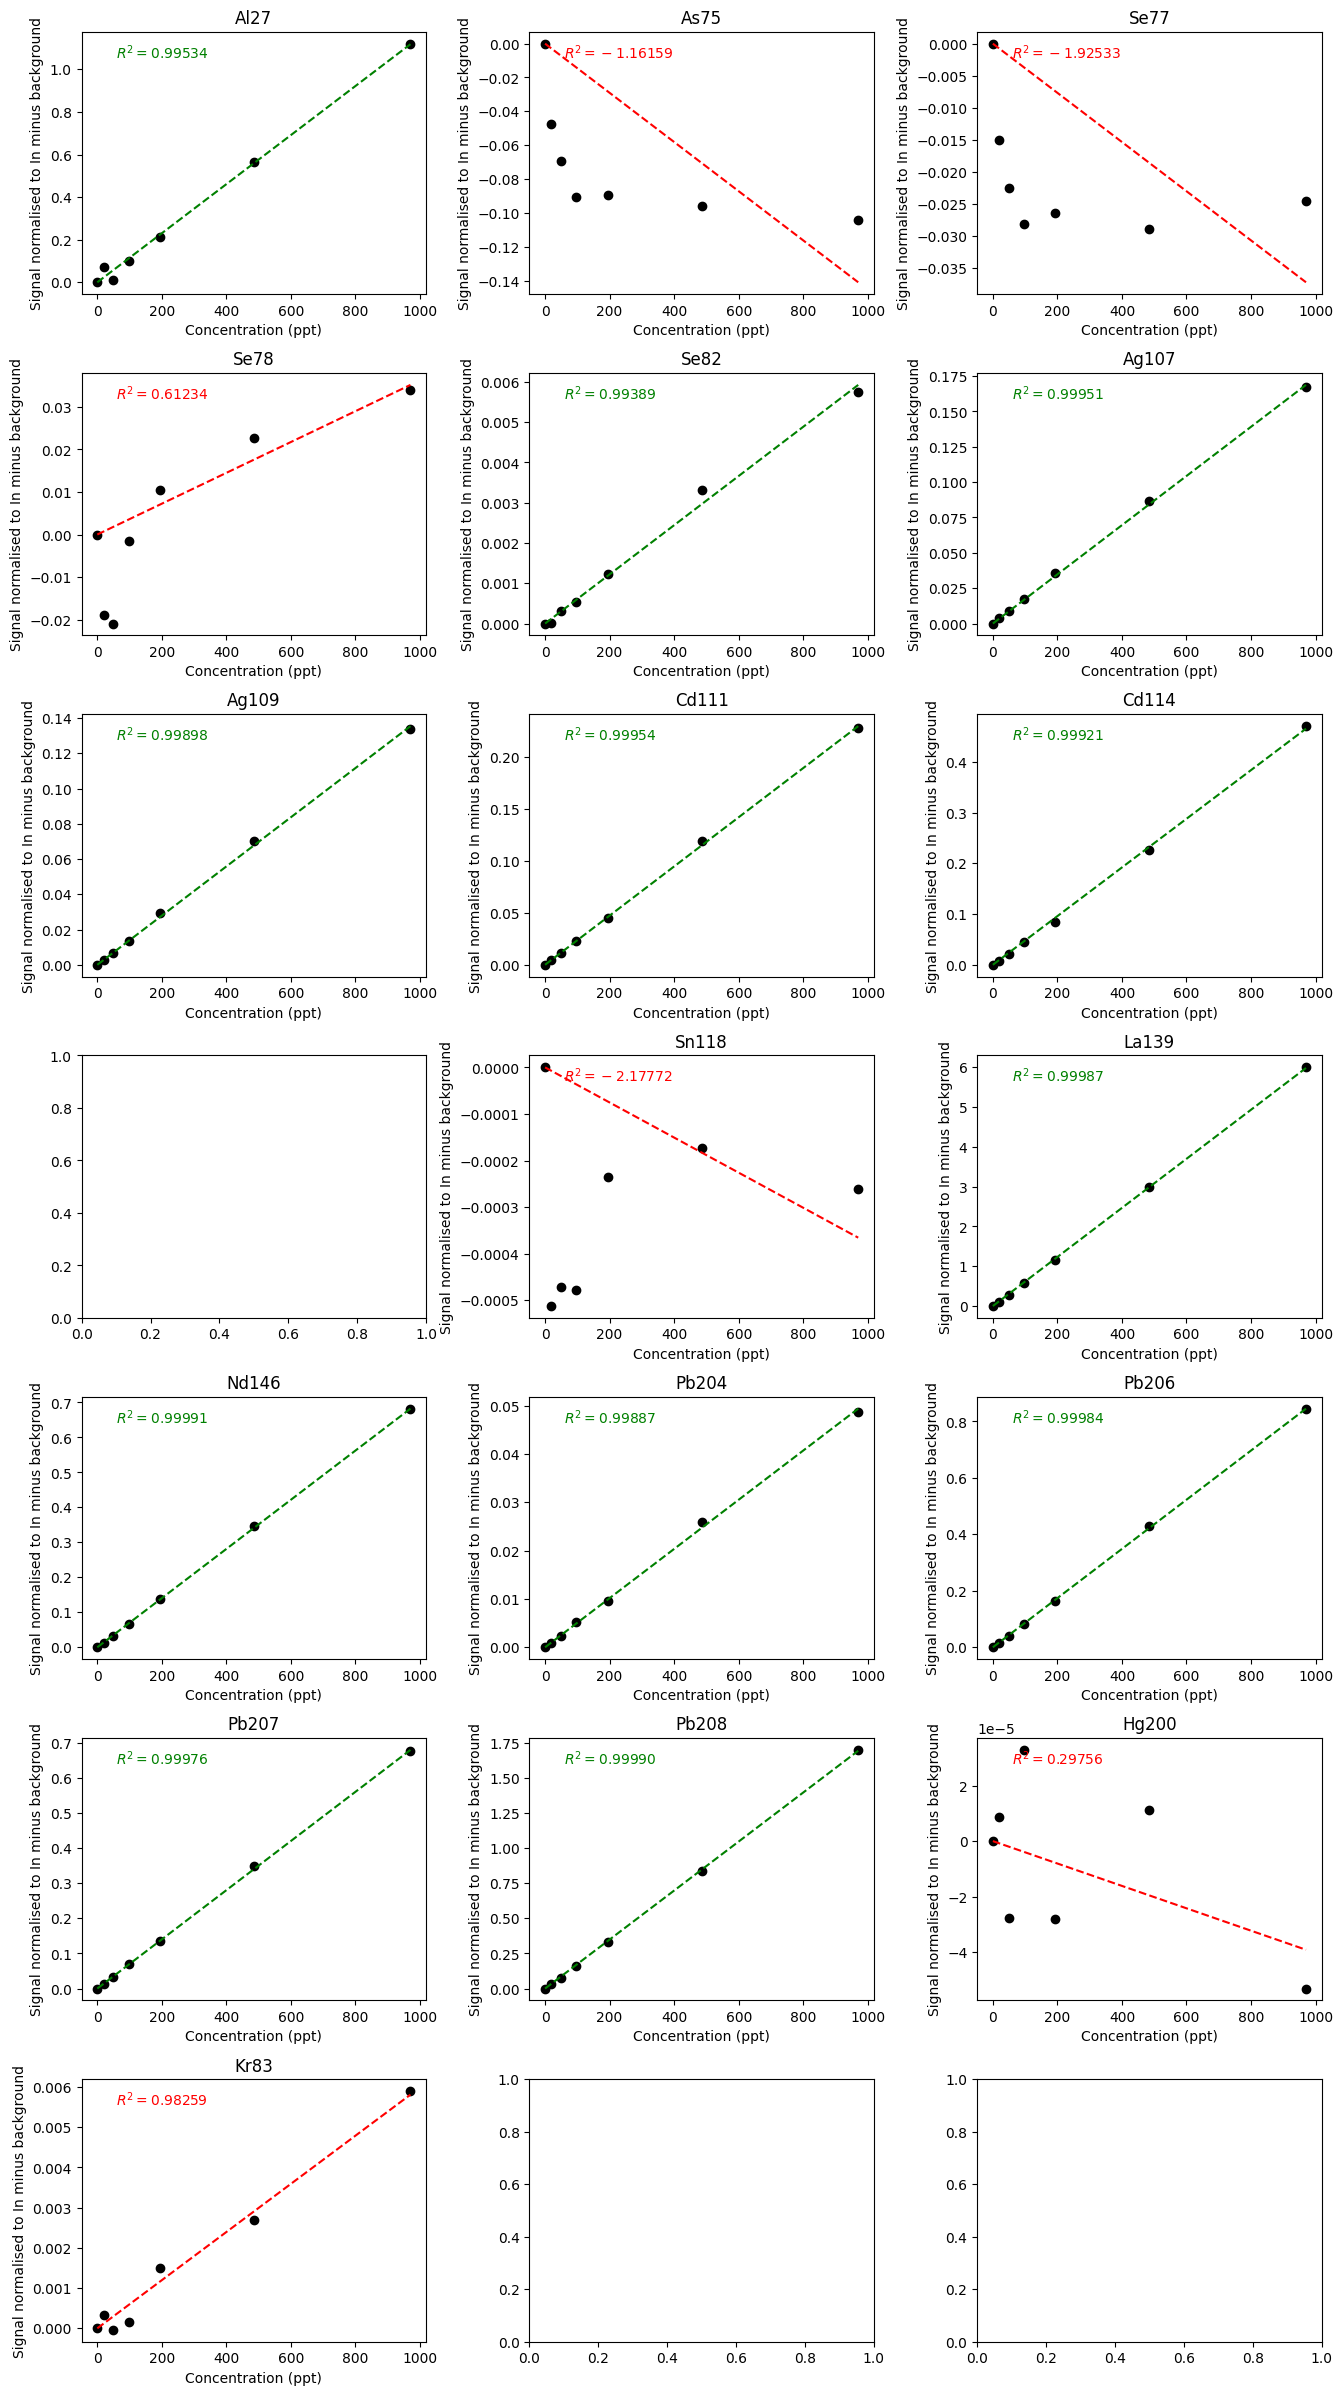

In [18]:
# ENTER STANDARD VALUES HERE (KEEP NAME FORMAT AS cal_ + standard concentration in ppb + ppb)
cal_stds = {'cal_100ppb': 99.8508, 'cal_10ppb': 8.9453, 'cal_1ppb': 0.9704, 'cal_0ppb': 0, 'cal_0ppt':0, 'cal_1000ppt': 970.4}

#Minimum r2 on calibrations
min_r2 = 0.99

concs, errors, units = calibration_calculation(summarydf, cal_stds, min_r2, elements)


In [19]:
display(concs)
display(errors)

with pd.ExcelWriter('Results.xlsx') as writer:
    concs.to_excel(writer, sheet_name=f'Concentrations ({units})')
    errors.to_excel(writer, sheet_name='Errors')


,Al27,As75,Se77,Se78,Se82,Ag107,Ag109,Cd111,Cd114,In115,Sn118,La139,Nd146,Pb204,Pb206,Pb207,Pb208,Hg200,Kr83
CON_Blank_10x,121.850872,NaN,NaN,NaN,-0.052718,-1.283452,-0.245866,0.077323,0.127798,NaN,NaN,0.010723,-0.096625,-0.766091,0.037025,-0.061024,0.064758,NaN,NaN
SMP_Blank,-195.870786,NaN,NaN,NaN,21.716066,10.418695,-0.451236,0.304005,-0.094643,NaN,NaN,0.152909,0.278883,-2.624547,0.145042,0.283838,0.080570,NaN,NaN
SMP_SW_10x,-106.969428,NaN,NaN,NaN,121.924689,11.501924,-0.756191,1.005811,1.054969,NaN,NaN,0.158575,0.139400,0.585434,1.533978,0.841110,1.260462,NaN,NaN
SMP_SW_1x,-227.464850,NaN,NaN,NaN,674.977571,5.853053,-0.725140,13.716763,12.182256,NaN,NaN,1.297580,0.717207,38.797218,8.724317,8.661989,8.011050,NaN,NaN
SMP_SW_2x,-173.033883,NaN,NaN,NaN,233.275583,11.175785,-1.974326,7.110562,5.127391,NaN,NaN,0.642050,0.317664,13.717254,4.766546,4.801136,3.781601,NaN,NaN
SMP_SW_5x,-164.170752,NaN,NaN,NaN,118.383421,13.877901,-1.216293,1.947253,1.860516,NaN,NaN,0.280528,0.133801,5.324521,2.199371,2.414601,1.847930,NaN,NaN
SMP_s1,-142.520024,NaN,NaN,NaN,151.695527,3.595669,-0.938320,56.624813,57.882898,NaN,NaN,3.382384,3.215374,82.695744,69.803287,76.858182,69.868908,NaN,NaN
SMP_s5,372.851485,NaN,NaN,NaN,111.444530,14.531108,9.111348,83.859712,79.953867,NaN,NaN,3.866243,2.594423,130.035988,137.136664,143.402649,135.323434,NaN,NaN
SMP_s9,667.038690,NaN,NaN,NaN,129.301496,5.752542,-0.466501,88.600357,80.212828,NaN,NaN,4.335402,3.479671,27.933433,26.705446,26.543375,25.011811,NaN,NaN
STD_0ppt_1x,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


,Al27,As75,Se77,Se78,Se82,Ag107,Ag109,Cd111,Cd114,In115,Sn118,La139,Nd146,Pb204,Pb206,Pb207,Pb208,Hg200,Kr83
CON_Blank_10x,4.015647,NaN,NaN,NaN,-0.000011,-0.002035,-0.000453,0.000163,0.000726,NaN,NaN,0.000316,-0.000273,-0.000543,0.000172,-0.000274,0.000484,NaN,NaN
SMP_Blank,-6.455004,NaN,NaN,NaN,0.004340,0.016521,-0.000832,0.000639,-0.000537,NaN,NaN,0.004502,0.000787,-0.001862,0.000675,0.001277,0.000602,NaN,NaN
SMP_SW_10x,-3.525222,NaN,NaN,NaN,0.024366,0.018239,-0.001393,0.002115,0.005990,NaN,NaN,0.004668,0.000393,0.000415,0.007142,0.003783,0.009413,NaN,NaN
SMP_SW_1x,-7.496200,NaN,NaN,NaN,0.134893,0.009281,-0.001336,0.028840,0.069175,NaN,NaN,0.038200,0.002024,0.027522,0.040620,0.038958,0.059824,NaN,NaN
SMP_SW_2x,-5.702404,NaN,NaN,NaN,0.046620,0.017722,-0.003638,0.014950,0.029115,NaN,NaN,0.018902,0.000896,0.009731,0.022193,0.021593,0.028240,NaN,NaN
SMP_SW_5x,-5.410316,NaN,NaN,NaN,0.023659,0.022006,-0.002241,0.004094,0.010565,NaN,NaN,0.008259,0.000378,0.003777,0.010240,0.010860,0.013800,NaN,NaN
SMP_s1,-4.696807,NaN,NaN,NaN,0.030316,0.005702,-0.001729,0.119057,0.328680,NaN,NaN,0.099575,0.009073,0.058664,0.324999,0.345674,0.521759,NaN,NaN
SMP_s5,12.287477,NaN,NaN,NaN,0.022272,0.023042,0.016790,0.176320,0.454006,NaN,NaN,0.113820,0.007321,0.092246,0.638499,0.644962,1.010554,NaN,NaN
SMP_s9,21.982540,NaN,NaN,NaN,0.025841,0.009122,-0.000860,0.186287,0.455477,NaN,NaN,0.127632,0.009818,0.019816,0.124339,0.119380,0.186780,NaN,NaN
STD_0ppt_1x,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
